<font size="+2">Double Deep Q-Learning & Open AI Gym: Intro</font>

# The Open AI Lunar Lander environment 

The [OpenAI Gym](https://gym.openai.com/) is a RL platform that provides standardized environments to test and benchmark RL algorithms using Python. It is also possible to extend the platform and register custom environments.

The [Lunar Lander](https://gym.openai.com/envs/LunarLander-v2) (LL) environment requires the agent to control its motion in two dimensions, based on a discrete action space and low-dimensional state observations that include position, orientation, and velocity. At each time step, the environment provides an observation of the new state and a positive or negative reward.  Each episode consists of up to 1,000 time steps. The following diagram shows selected frames from a successful landing after 250 episodes by the agent we will train:

<img src="img/lunar_lander.png" width="700">

More specifically, the agent observes eight aspects of the state, including six continuous and two discrete elements. Based on the observed elements, the agent knows its location, direction, speed of movement, and whether it has (partially) landed. However, it does not know where it should be moving using its available actions or observe the inner state of the environment in the sense of understanding the rules that govern its motion.

At each time step, the agent controls its motion using one of four discrete actions. It can do nothing (and continue on its current path), fire its main engine (to reduce downward motion), or steer to the left or right using the respective orientation engines. There are no fuel limitations.

The goal is to land the agent between two flags on a landing pad at coordinates (0, 0), but landing outside of the pad is possible. The agent accumulates rewards in the range of 100-140 for moving toward the pad, depending on the exact landing spot. However, moving away from the target negates the reward the agent would have gained by moving toward the pad. Ground contact by each leg adds ten points, and using the main engine costs -0.3 points.

An episode terminates if the agent lands or crashes, adding or subtracting 100 points, respectively, or after 1,000 time steps. Solving LL requires achieving a cumulative reward of at least 200 on average over 100 consecutive episodes.

# Deep Q-Learning

Deep Q learning estimates the value of the available actions for a given state using a deep neural network. It was introduced by Deep Mind's [Playing Atari with Deep Reinforcement Learning](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf) (2013), where RL agents learned to play games solely from pixel input.

The Deep Q-Learning algorithm approximates the action-value function q by learning a set of weights  of a multi-layered Deep Q Network (DQN) that maps states to actions so that $$q(s,a,\theta)\approx q^*(s,a)$$

The algorithm applies gradient descent to a loss function defined as the squared difference between the DQN's estimate of the target 
$$y_i=\mathbb{E}[r+\gamma\max_{a^\prime}Q(s^\prime, a^\prime; \theta_{i−1}\mid s,a)]$$ 
and its estimate of the action-value of the current state-action pair  to learn the network parameters:

$$L_i(\theta_i)=\mathbb{E}\left[\left(\overbrace{\underbrace{y_i}_{\text{Q Target}}−\underbrace{Q(s, a; \theta)}_{\text{Current Prediction}}}^{\text{TD Error}}\right)^2 \right]$$

Both the target and the current estimate depend on the set of weights, underlining the distinction from supervised learning where targets are fixed prior to training. 

## Extensions

Several innovations have improved the accuracy and convergence speed of deep Q-Learning, namely:
- **Experience replay** stores a history of state, action, reward, and next state transitions and randomly samples mini-batches from this experience to update the network weights at each time step before the agent selects an ε-greedy action. It increases sample efficiency, reduces the autocorrelation of samples, and limits the feedback due to the current weights producing training samples that can lead to local minima or divergence.
- **Slowly-changing target network** weakens the feedback loop from the current network parameters on the neural network weight updates. Also invented by by Deep Mind in [Human-level control through deep reinforcement learning](https://web.stanford.edu/class/psych209/Readings/MnihEtAlHassibis15NatureControlDeepRL.pdf) (2015), it use a slowly-changing target network that has the same architecture as the Q-network, but its weights are only updated periodically. The target network generates the predictions of the next state value used to update the Q-Networks estimate of the current state's value.
- **Double deep Q-learning** addresses the bias of deep Q-Learning to overestimate action values because it purposely samples the highest action value. This bias can negatively affect the learning process and the resulting policy if it does not apply uniformly , as shown by Hado van Hasselt in [Deep Reinforcement Learning with Double Q-learning](https://arxiv.org/abs/1509.06461) (2015). To decouple the estimation of action values from the selection of actions, Double Deep Q-Learning (DDQN) uses the weights, of one network to select the best action given the next state, and the weights of another network to provide the corresponding action value estimate.


# Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
from time import time
from pathlib import Path

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# OpenAI Gym
import gym
from gym import wrappers

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style('whitegrid', {'axes.grid' : False})

In [4]:
# uncomment to run multiple experiments in parallel:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu_devices[0], True)

Set random seeds to ensure results can be reproduced:

In [5]:
np.random.seed(42)
tf.random.set_seed(42)

## Result display helper functions

In [6]:
def format_time(t):
    m_, s = divmod(t, 60)
    h, m = divmod(m_, 60)
    return '{:02.0f}:{:02.0f}:{:02.0f}'.format(h, m, s)

## Enable virtual display to run from docker container

This is only required if you run this on server that does not have a display.

In [7]:
# from pyvirtualdisplay import Display
# virtual_display = Display(visible=0, size=(1400, 900))
# virtual_display.start()

# Define DDQN Agent

We will use [TensorFlow](https://www.tensorflow.org/) to create our Double Deep Q-Network .

## Replay Buffer

In [8]:
class Memory():
    def __init__(self, capacity, state_dims):
        self.capacity = capacity
        self.idx = 0

        self.state_memory = np.zeros(shape=(capacity, state_dims), 
                                     dtype=np.float32)
        self.new_state_memory = np.zeros_like(self.state_memory)

        self.action_memory = np.zeros(capacity, dtype=np.int32)
        self.reward_memory = np.zeros_like(self.action_memory)
        self.done = np.zeros_like(self.action_memory)

    def store(self, state, action, reward, next_state, done):
        self.state_memory[self.idx, :] = state
        self.new_state_memory[self.idx, :] = next_state
        self.reward_memory[self.idx] = reward
        self.action_memory[self.idx] = action
        self.done[self.idx] = 1 - int(done)
        self.idx += 1

    def sample(self, batch_size):
        batch = np.random.choice(self.idx, batch_size, replace=False)

        states = self.state_memory[batch]
        next_states = self.new_state_memory[batch]
        rewards = self.reward_memory[batch]
        actions = self.action_memory[batch]
        done = self.done[batch]
        return states, actions, rewards, next_states, done

## Agent Class

In [9]:
class DDQNAgent:
    def __init__(self,
                 state_dim,
                 num_actions,
                 gamma,
                 epsilon_start,
                 epsilon_end,
                 epsilon_decay_steps,
                 epsilon_exponential_decay,
                 learning_rate,
                 architecture,
                 l2_reg,
                 replay_capacity,
                 tau,
                 batch_size,
                 results_dir,
                 log_every=10):

        self.state_dim = state_dim
        self.num_actions = num_actions

        self.architecture = architecture
        self.l2_reg = l2_reg
        self.learning_rate = learning_rate
        self.experience = Memory(replay_capacity,
                                 state_dim)
        self.gamma = gamma
        self.tau = tau
        self.batch_size = batch_size
        self.idx = np.arange(batch_size, dtype=np.int32)

        self.online_network = self.build_model()
        self.target_network = self.build_model(trainable=False)
        self.optimizer = Adam(lr=learning_rate)
        self.update_target()

        self.epsilon = epsilon_start
        self.epsilon_decay_steps = epsilon_decay_steps
        self.epsilon_decay = (epsilon_start - epsilon_end) / epsilon_decay_steps
        self.epsilon_exponential_decay = epsilon_exponential_decay
        self.epsilon_history = []

        self.total_steps = self.train_steps = 0
        self.episodes = self.episode_length = self.train_episodes = 0
        self.steps_per_episode = []
        self.episode_reward = 0
        self.rewards_history = []

        self.results_dir = results_dir
        self.experiment = experiment
        self.log_every = log_every
        
        self.summary_writer = (tf.summary
                               .create_file_writer(results_dir.as_posix()))
        self.start = time()
        self.train = True

    def build_model(self, trainable=True):
        layers = []
        for i, units in enumerate(self.architecture, 1):
            layers.append(Dense(units=units,
                                input_dim=self.state_dim if i == 1 else None,
                                activation='relu',
                                kernel_regularizer=l2(self.l2_reg),
                                trainable=trainable))
        layers.append(Dense(units=self.num_actions,
                            trainable=trainable))
        return Sequential(layers)

    def update_target(self):
        self.target_network.set_weights(self.online_network.get_weights())

    # @tf.function
    def epsilon_greedy_policy(self, state):
        self.total_steps += 1
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.num_actions)
        q = self.online_network.predict(state)
        return np.argmax(q, axis=1).squeeze()

    # @tf.function
    def decay_epsilon(self):
        if self.train:
            if self.episodes < self.epsilon_decay_steps:
                self.epsilon -= self.epsilon_decay
            else:
                self.epsilon *= self.epsilon_exponential_decay

    def log_progress(self):
        self.rewards_history.append(self.episode_reward)
        self.steps_per_episode.append(self.episode_length)

        avg_steps_100 = np.mean(self.steps_per_episode[-100:])
        avg_steps_10 = np.mean(self.steps_per_episode[-10:])
        max_steps_10 = np.max(self.steps_per_episode[-10:])
        avg_rewards_100 = np.mean(self.rewards_history[-100:])
        avg_rewards_10 = np.mean(self.rewards_history[-10:])
        max_rewards_10 = np.max(self.rewards_history[-10:])

        with self.summary_writer.as_default():
            tf.summary.scalar('Episode Reward', self.episode_reward, step=self.episodes)
            tf.summary.scalar('Episode Rewards (MA 100)', avg_rewards_100, step=self.episodes)
            tf.summary.scalar('Episode Steps', self.episode_length, step=self.episodes)
            tf.summary.scalar('Epsilon', self.epsilon, step=self.episodes)

        if self.episodes % self.log_every == 0:
            template = '{:03} | {} | Rewards {:4.0f} {:4.0f} {:4.0f} | ' \
                       'Steps: {:4.0f} {:4.0f} {:4.0f} | Epsilon: {:.4f}'
            print(template.format(self.episodes, format_time(time() - self.start),
                                  avg_rewards_100, avg_rewards_10, max_rewards_10,
                                  avg_steps_100, avg_steps_10, max_steps_10,
                                  self.epsilon))

    def memorize_transition(self, s, a, r, s_prime, done):
        self.experience.store(s, a, r, s_prime, done)
        self.episode_reward += r
        self.episode_length += 1

        if done:
            self.epsilon_history.append(self.epsilon)
            self.decay_epsilon()
            self.episodes += 1
            self.log_progress()
            self.episode_reward = 0
            self.episode_length = 0

    def experience_replay(self):
        # not enough experience yet
        if self.batch_size > self.experience.idx:
            return

        # sample minibatch
        states, actions, rewards, next_states, done = self.experience.sample(self.batch_size)

        # select best next action (online)
        next_action = tf.argmax(self.online_network.predict(next_states, self.batch_size), axis=1, name='next_action')
        # predict next q values (target)
        next_q_values = self.target_network.predict(next_states, self.batch_size)
        # get q values for best next action
        target_q = (tf.math.reduce_sum(next_q_values *
                                       tf.one_hot(next_action,
                                                  self.num_actions),
                                       axis=1, name='target_q'))
        # compute td target
        td_target = rewards + done * self.gamma * target_q

        with tf.GradientTape() as tape:
            q_values = self.online_network(states)
            q_values = tf.math.reduce_sum(q_values * tf.one_hot(actions, self.num_actions), axis=1, name='q_values')
            loss = tf.math.reduce_mean(tf.square(td_target - q_values))

        # run back propagation
        variables = self.online_network.trainable_variables
        gradients = tape.gradient(loss, variables)

        self.optimizer.apply_gradients(zip(gradients, variables))
        with self.summary_writer.as_default():
            tf.summary.scalar('Loss', loss, step=self.train_steps)
        self.train_steps += 1

        if self.total_steps % self.tau == 0:
            self.update_target()

    def store_results(self):
        result = pd.DataFrame({'Rewards': self.rewards_history,
                               'Steps'  : self.steps_per_episode,
                               'Epsilon': self.epsilon_history},
                              index=list(range(1, len(self.rewards_history) + 1)))

        result.to_csv(self.results_dir / 'results.csv', index=False)

# Run Experiment

In [10]:
experiment = 0

In [11]:
results_dir = Path('results', 'lunar_lander', 'experiment_{}'.format(experiment))
if not results_dir.exists():
    results_dir.mkdir(parents=True)

## Set up OpenAI Gym Lunar Lander Environment

We will begin by instantiating and extracting key parameters from the LL environment:

In [12]:
env = gym.make('LunarLander-v2')
state_dim = env.observation_space.shape[0]  # number of dimensions in state
num_actions = env.action_space.n  # number of actions
max_episode_steps = env.spec.max_episode_steps  # max number of steps per episode
env.seed(42)

[42]

We will also use the built-in wrappers that permit the periodic storing of videos that display the agent's performance:

In [13]:
monitor_path = results_dir / 'monitor'
video_freq = 500

In [14]:
env = wrappers.Monitor(env,
                       directory=monitor_path.as_posix(),
                       video_callable=lambda count: count % video_freq == 0,
                      force=True)

## Define hyperparameters

The agent's performance is quite sensitive to several hyperparameters. We will start with the discount before setting the Q-Network, replay buffer, and ε-greedy policy parameters.

### Discount Factor

In [15]:
gamma = .99

### Q-Network Parameters

In [16]:
learning_rate = 0.0001

In [17]:
architecture = (256, 256)  # units per layer
l2_reg = 1e-6  # L2 regularization

We will update the target network every 100 time steps, store up to 1 m past episodes in the replay memory, and sample mini-batches of 1,024 from memory to train the agent:

### Replay Buffer Parameters

In [18]:
tau = 100  # target network update frequency
replay_capacity = int(1e6)
batch_size = 1024

### ε-greedy Policy

The ε-greedy policy starts with pure exploration at ε=1 and linearly decays every step to 0.01 over 100 episodes, followed by exponential decay at rate 0.99:

In [19]:
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay_steps = 100
epsilon_exponential_decay = .99

## Instantiate DDQN Agent

In [20]:
agent = DDQNAgent(state_dim=state_dim,
                  num_actions=num_actions,
                  learning_rate=learning_rate,
                  gamma=gamma,
                  epsilon_start=epsilon_start,
                  epsilon_end=epsilon_end,
                  epsilon_decay_steps=epsilon_decay_steps,
                  epsilon_exponential_decay=epsilon_exponential_decay,
                  replay_capacity=replay_capacity,
                  architecture=architecture,
                  l2_reg=l2_reg,
                  tau=tau,
                  batch_size=batch_size,
                  results_dir=results_dir)

## Train & test agent

In [21]:
tf.keras.backend.clear_session()

In [22]:
max_episodes = 2500
test_episodes = 0

Besides the episode number an elapsed time, we log the moving averages for the last 100 and last 10 rewards and episode lengths, as well as their respective maximum values over the last 10 iterations. We also track the decay of epsilon. 

In [23]:
while agent.episodes < max_episodes:
    this_state = env.reset()
    done = False
    while not done:
        action = agent.epsilon_greedy_policy(this_state.reshape(-1, state_dim))
        next_state, reward, done, _ = env.step(action)
        agent.memorize_transition(this_state, action, reward, next_state, done)
        agent.experience_replay()
        this_state = next_state
    if np.mean(agent.rewards_history[-100:]) > 200:
        break

agent.store_results()
env.close()

010 | 00:00:03 | Rewards -193 -193  -70 | Steps:   93   93  143 | Epsilon: 0.9010
020 | 00:00:36 | Rewards -166 -139  -59 | Steps:   99  105  178 | Epsilon: 0.8020
030 | 00:01:15 | Rewards -157 -138   -6 | Steps:  104  112  140 | Epsilon: 0.7030
040 | 00:02:02 | Rewards -137  -78   42 | Steps:  109  126  179 | Epsilon: 0.6040
050 | 00:02:59 | Rewards -120  -50  -10 | Steps:  116  144  258 | Epsilon: 0.5050
060 | 00:04:40 | Rewards -107  -45   20 | Steps:  137  241  523 | Epsilon: 0.4060
070 | 00:08:38 | Rewards  -98  -41   63 | Steps:  199  573 1000 | Epsilon: 0.3070
080 | 00:14:35 | Rewards  -91  -39   17 | Steps:  283  872 1000 | Epsilon: 0.2080
090 | 00:21:15 | Rewards  -71   82  234 | Steps:  355  928 1000 | Epsilon: 0.1090
100 | 00:25:49 | Rewards  -52  122  258 | Steps:  380  602 1000 | Epsilon: 0.0100
110 | 00:30:33 | Rewards  -30   29  239 | Steps:  429  584  860 | Epsilon: 0.0090
120 | 00:34:52 | Rewards   -4  115  284 | Steps:  471  529 1000 | Epsilon: 0.0082
130 | 00:38:12 |

## Evaluate Results

In [25]:
results = pd.read_csv(results_dir / 'results.csv')
results['MA100'] = results.rolling(window=100, min_periods=25).Rewards.mean()

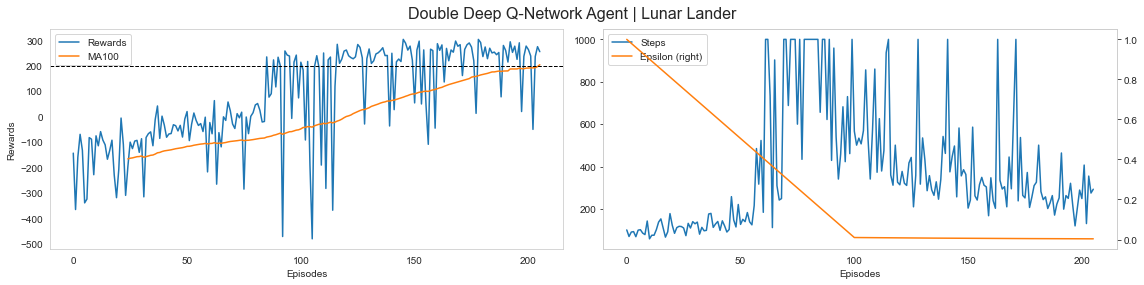

In [29]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 4), sharex=True)
results[['Rewards', 'MA100']].plot(ax=axes[0])
axes[0].set_ylabel('Rewards')
axes[0].set_xlabel('Episodes')
axes[0].axhline(200, c='k', ls='--', lw=1)
results[['Steps', 'Epsilon']].plot(secondary_y='Epsilon', ax=axes[1]);
axes[1].set_xlabel('Episodes')
fig.suptitle('Double Deep Q-Network Agent | Lunar Lander', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=.9)
fig.savefig('figures/trading_agent_2ed', dpi=300)

## Tensorboard

In [27]:
%load_ext tensorboard

In [28]:
%tensorboard --logdir results/lunar_lander/experiment_0

Reusing TensorBoard on port 6013 (pid 6249), started 1:09:30 ago. (Use '!kill 6249' to kill it.)